In [1]:
from pyspark import SparkContext
from pyspark.sql import SQLContext, Row,SparkSession
import pandas as pd
from pyspark.ml.feature import StringIndexer,IndexToString
from pyspark.ml.feature import OneHotEncoder
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import pandas as pd
matplotlib.rcParams['font.family'] = 'Malgun Gothic'
matplotlib.rcParams['axes.unicode_minus'] = False
import pyspark.sql.functions as f
from pyspark.sql.types import DoubleType, IntegerType, StringType
sqlCtx = SparkSession.builder.appName('test').getOrCreate()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


22/12/26 13:24:53 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [2]:
train = sqlCtx.read.csv('open/train.csv', header=True, encoding='cp949',inferSchema=True)
test = sqlCtx.read.csv('open/test.csv', header=True, encoding='cp949',inferSchema=True)

In [3]:
c = ['id', 'father', 'mother', 'gender']
train_x = train.drop(*c)
test_x = test.drop(*c)

In [4]:
snp_col = [f'SNP_{str(x).zfill(2)}' for x in range(1,16)]
snp_col_lab = [f'SNP_lab_{str(x).zfill(2)}' for x in range(1,16)]
indexer = StringIndexer(inputCols=snp_col, outputCols=snp_col_lab)
outdexer =StringIndexer(inputCol='class', outputCol='class_lab')
train_X = indexer.fit(train_x).transform(train_x)
test_X = indexer.fit(train_x).transform(test_x)
train_X = outdexer.fit(train_X).transform(train_X)

22/12/26 13:25:28 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


Text(0.5, 0.98, 'Main')

findfont: Font family ['Malgun Gothic'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Malgun Gothic'] not found. Falling back to DejaVu Sans.


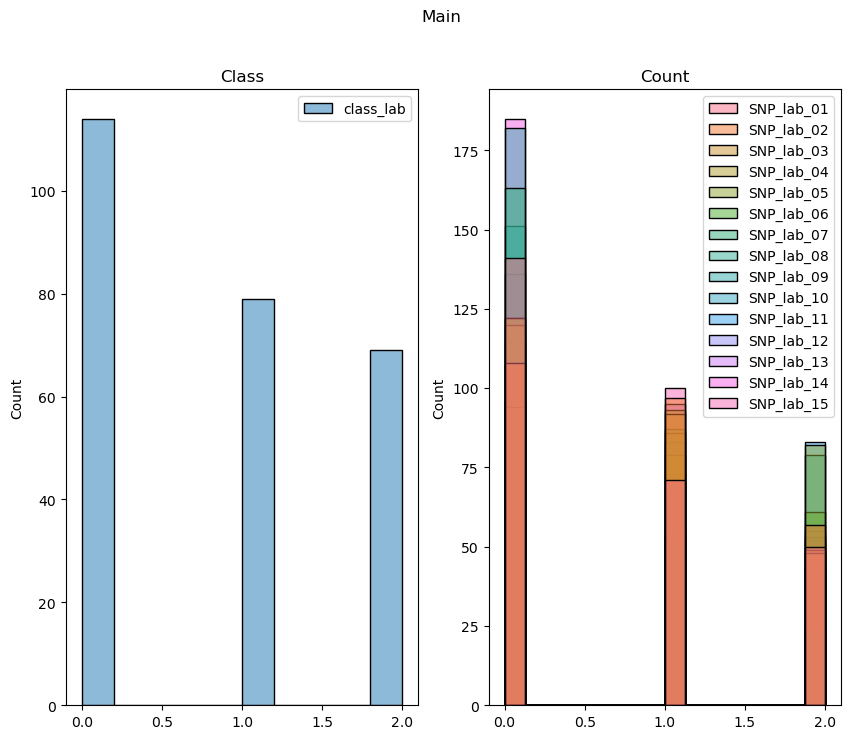

In [5]:
fig, axes = plt.subplots(1, 2, figsize=(10,8))
sns.histplot(data = train_X.select('class_lab').toPandas(), ax = axes[0])
sns.histplot(data = train_X.select(snp_col_lab).toPandas(), ax = axes[1])
axes[0].set_title("Class")
axes[1].set_title("Count")
plt.suptitle("Main")

In [6]:
train_X = train_X.drop(*snp_col)
test_X = test_X.drop(*snp_col)
train_X = train_X.drop('class')

In [7]:
snp_col_lab.insert(0,'trait')
fea = VectorAssembler( inputCols= snp_col_lab,
                     outputCol = 'features' )
                     
train_df = fea.transform( train_X)
test = fea.transform(test_X)

In [8]:
train_df, test_df = train_df.randomSplit([0.8, 0.2], seed=43 )

In [9]:
lr = LogisticRegression(maxIter=1000, elasticNetParam = 0.5, featuresCol="features",
               labelCol="class_lab")
lrModel = lr.fit(train_df)

22/12/26 13:25:53 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
22/12/26 13:25:53 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.ForeignLinkerBLAS


In [10]:
lr_predict = lrModel.transform( test_df )

In [12]:
evaluator = MulticlassClassificationEvaluator(
 labelCol="class_lab",  predictionCol="prediction",
    metricName="accuracy")
print(  evaluator.evaluate(lr_predict) )

0.9583333333333334


In [13]:
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
predictions_pdf = lr_predict.toPandas()
cumulative_stats = predictions_pdf.groupby(['prediction']).count()
product_data = [go.Pie(labels=cumulative_stats.index, values=cumulative_stats.rawPrediction)]
product_layout = go.Layout(title='Predicted product distribution')

fig = go.Figure(data=product_data, layout=product_layout)
iplot(fig)

In [14]:
decoding ={0.0:'A', 1.0:'B',2.0:'C'}
ff =f.udf(lambda v : decoding[v])
lr_predict = lrModel.transform( test )
lr_predict = lr_predict.withColumn('prediction', ff(lr_predict['prediction']))
lr_predict.select('prediction').show()


+----------+
|prediction|
+----------+
|         C|
|         A|
|         B|
|         A|
|         C|
|         A|
|         B|
|         A|
|         C|
|         C|
|         B|
|         A|
|         A|
|         C|
|         A|
|         A|
|         C|
|         A|
|         A|
|         B|
+----------+
only showing top 20 rows

